# Final Project
#### Assigned: 2019-05-09
#### Due EoD: 2019-05-22

Intraday ETF trading based on 10-sec aggregated equity market data.

#### Name:  Mengheng Xue
#### NetID: mx586

## Data Set

SPY is an Exchange Traded Fund (ETF) that replicates the S&P 500 index, and trades in exchanges like ordinary equity.  
SPY is the most liquid (heavily traded) equity asset in the US.  

For all trading days in June 2018 we have aggregated in 10-sec intervals the trading activity in SPY across all exchanges.  
The dataset is provided in the file `Resources/Data/spy-10sec-201806.csv` at the class site.   
Each row corresponds to a specific 10-sec interval for the corresponding trading day.  
A row reports trading activity within the time period that *ends* at the corresponding interval.  

Regular trading hours in the US are from 09:30 to 16:00.  
You will notice that the 09:30 and 16:00 intervals have much larger traded volume relative to neighboring ones.  
This is because the market opens at 09:30 with an opening auction and closes at 16:00 with a closing auction.  
The consolidated limit order book is the collection of all quotes to buy (bid) and to sell (ask).  
Bid and ask prices/sizes are quotes, i.e. proposals to trade a given quantity at a given price.  
VWAP is the volume weighted average of prices at which trades actually occurred.  




|Column              | Description  |
---------------------|--------------|
|volume              | Number of shares traded within the interval  ($\sum_i V_i $,   summing over all trades $i$)          |
|vwap                | Volume Weighted Average Price ( $VWAP = \sum_i V_i P_i / \sum_i V_i$,   summing over all trades $i$) |
|lowPx/highPx        | Lowest and highest trade prices within the interval                               |
|lastBidPx/lastAskPx | Last bid and ask price in the interval                         |
|lastBidSz/lastAskSz | Last bid and ask sizes (in hundreds of shares) in the interval |


#### Feature engineering

Derived quantities of interest are

1. The Close Location Value (CLV) indicator. This is an intraday adaptation of a classic technical indicator. It is defined as  
$$
CLV_t = \frac{VWAP_t - (lowPx_t + highPx_t)/2}{(highPx_t - lowPx_t)/2}
$$
It measures the location of the VWAP within interval $t$, relative to the mid-point price between low and high price.  

2. The last *quote imbalance* of interval $t$, defined as 
$$
Imbal_t = \frac{lastBidSz_t - lastAskSz_t}{lastBidSz_t + lastAskSz_t}
$$
By construction $-1 \le Imbal \le 1$.  
When $Imbal \rightarrow 1$, there is much more interest to buy than to sell. 
Conversely, when $Imbal \rightarrow -1$ there is much more interest to sell than to buy.  

3. The log-transformed volume defined as $logVolume = log10(Volume)$  
When working with volume-like quantities (non-negative) taking logs is a common normalization.  
Either base 10 or natural logs can be used, base 10 logs may be easier to interpret.

We are also interested in the $N$-period forward return in basis points
$$
\mathrm{fwdRetNBps}_t = 10000 * \left(\frac{VWAP_{t+N}}{VWAP_t} - 1\right)
$$

## Problem (100 points)

#### Objective
+ Construct ML models that use features derived from market observables, to predict price direction in future periods
+ Assess the models using 10-sec as well as 1-min aggregation periods

#### Data Preparation (30 points)
+ Load the SPY 10-sec data
+ Calculate the CLV and the last quote imbalance for each interval. If highPx is equal to lowPx for an interval, set the CLV value to 0.
+ Calculate the 1-period forward VWAP returns in basis points
+ Split the dataset into training sample with the first 16 days, and testing sample with the remaining 4 trading days.
+ Use the average VWAP in the training set a reference price. Call this $\mathrm{RefPx}$.
+ Compute a cutoff return in basis points as:  $\mathrm{cutRetBps} = 10000 * (0.02) / \mathrm{RefPx}$  
  This return corresponds to VWAP movement of twice the typical bid-ask spread (i.e 2 * 0.01)
+ Add a new column called pxDir1 (price direction) and label the 1-period forward price movement as follows:  
  * If fwdRet1Bps > cutRetBps then pxDir1 = +1  
  * If abs(fwdRet1Bps) <= cutRetBps then pxDir1 = 0  
  * If fwdRet1Bps < - cutRet1Bps then pxDir1 = -1  
  Therefore pxDir is a class variable taking values in the set $\{-1, 0, 1\}$.
+ Re-aggregate the 10-sec data into 1-min data and store them in a new data frame.
+ Repeat the process above (CLV, quote imbalance, forward returns, price direction labeling) with the 1-min data.

#### Modeling (60 points)

+ Exploratory data analysis (EDA) which should contain:   
    * univariate distributions of features: logVolume, clv, imbalance  
    * univariate distributions of targets: fwdRet1Bps, pxDir1  
    * any other distribution that may reveal a relationship between target and features  
    * correlation heat map  
+ Construction of a *baseline* model, to be used as a reference.  
  The baseline model predicts the price direction class $C=\{-1, 0, 1\}$ randomly using the class empirical probability of occurence.  
$$
\mathbb{P}(C=\pm 1) = \frac{N_{train}(C=\pm 1)}{N_{train}}, \quad 
\mathbb{P}(C=0) = \frac{N_{train}(C=0)}{N_{train}}
$$
Estimate the empirical probabilities of the baseline model using the training set.  
Make predictions for pxDir1 (simply sample the multinomial distribution) and use the testing set to report  

|Model               | Accuracy  | Precision  | Recall | F1wght | F1micro | 
---------------------|-----------|------------|--------|---------|---------|
|Baseline            | ...       | ...        | ...    | ...     | ...     |

Precision, Recall and F1wght should be measured "weighted" to account for class occurence and potential imbalance.  
F1micro is the "micro" F1 score, i.e. it first computes total true/false positives/negatives first and then computes the F1 score.

+ Construct *two* models, of which one should be neural net based.  
  The other could be any of the classic ML models (Logistic, SVM, Forest, AdaBoost, ...)  
  Train and tune the models in order to forecast the target variable pxDir1.  
  Evaluate the models on the test sample and add their performance metrics to the table above.  
  
+ Reaggregate the data using 1-min intervals and repeat the model runs 

+ Present your conclusions about the best model on the 10-sec and 1-min aggregated data

#### Extra Improvement (10 points)

Attempt to improve model performance by introducing one extra feature variable, derived from the existing market data.  
The extra variable could be either some kind of moving average or an intraday adaptation of a technical indicator.  
Measure the performance improvement for the 10-sec and 1-min dataset.

#### Submission Format

* Follow the submission rules for homeworks.  
* The main document is this notebook, describing the methodology and the conclusions.  
* Make sure your notebook runs using the standard packages we used in class: numpy/scipy/sklearn/statsmodels/tensorflow/keras.
* You can write your own utility classes and functions in separate source code files and import them into this notebook.  
* Assume that your separate source code files will be side-by-side with the notebook. 
* If you are submitting multiple files, put them in a zip archive.

Good luck.

## Solution

### Import Libraries 

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import seaborn as sns
%matplotlib inline 
# ====================plot setting ===============
pd.options.display.max_colwidth = 70

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.8)

### Data Preparation 

In [3]:
# Load the SPY 10-sec data
names = ['date', 'time', 'sym', 'volume', 'vwap', 'lowPx', 'highPx', 'lastBidPx', 'lastAskPx', 'lastBidSz', 'lastAskSz']
dataset = pd.read_csv('spy-10sec-201806.csv', skiprows=1, names=names)
df_10sec = dataset.copy()
df_10sec.head(5)

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz
0,2018-06-01,09:30:00,SPY,395424,272.459140,272.320007,272.489990,272.359985,272.380005,14,100
1,2018-06-01,09:30:10,SPY,55692,272.395593,272.339996,272.489990,272.399994,272.410004,9,50
2,2018-06-01,09:30:20,SPY,85164,272.443104,272.390015,272.470001,272.450012,272.459991,18,7
3,2018-06-01,09:30:30,SPY,26973,272.441112,272.420013,272.459991,272.429993,272.440002,5,20
4,2018-06-01,09:30:40,SPY,77809,272.440219,272.410004,272.480011,272.420013,272.429993,1,13


#### update CLV, last quote imbalance, log volume, and 1-period forward price return in dataframe

In [4]:
# funciton to calculate Close Location Value
def calculate_clv(vwap, lowPx, highPx):
    if lowPx == highPx:
        clv = 0
    else:
         clv = (vwap-(lowPx+highPx)/2) / ((highPx-lowPx)/2)
    return clv

# function to calculate last quote imbalance
def calculate_Imbal(lastBidSz, lastAskSz):
    imbal = (lastBidSz - lastAskSz)/(lastBidSz+lastAskSz)
    return imbal

# function to calculate N-period forward return in basis points, default is 1-period 
def calculate_fwdRetNBps(df, period=1):
    for i in range(0, len(df)-period):
        df.loc[i, 'fwdRet1Bps'] = 10000 * (df.loc[i+period, 'vwap']/df.loc[i, 'vwap'] - 1)
    return df 

# function to calcuate log10 volume
def calculate_logVolume(volume):
    logVolume = np.log10(volume)
    return logVolume

# function to update clv, lmbal, logVolume and fwdRetNBps of dataframe 
def update_features(df):
    df['logVolume'] = df.apply(lambda x: calculate_logVolume(x.volume), axis=1)
    df['clv'] = df.apply(lambda x: calculate_clv(x.vwap, x.lowPx, x.highPx), axis=1)
    df['Imbal'] = df.apply(lambda x: calculate_Imbal(x.lastBidSz, x.lastAskSz), axis=1)
    df = calculate_fwdRetNBps(df)
    return df

df_10sec = update_features(df_10sec)   
df_10sec.head(5)

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz,logVolume,clv,Imbal,fwdRet1Bps
0,2018-06-01,09:30:00,SPY,395424,272.459140,272.320007,272.489990,272.359985,272.380005,14,100,5.597063,0.637020,-0.754386,-2.332345
1,2018-06-01,09:30:10,SPY,55692,272.395593,272.339996,272.489990,272.399994,272.410004,9,50,4.745793,-0.258679,-0.694915,1.744181
2,2018-06-01,09:30:20,SPY,85164,272.443104,272.390015,272.470001,272.450012,272.459991,18,7,4.930256,0.327454,0.440000,-0.073097
3,2018-06-01,09:30:30,SPY,26973,272.441112,272.420013,272.459991,272.429993,272.440002,5,20,4.430929,0.055529,-0.600000,-0.032791
4,2018-06-01,09:30:40,SPY,77809,272.440219,272.410004,272.480011,272.420013,272.429993,1,13,4.891030,-0.136794,-0.857143,-0.013157


#### update price direction in dataframe and splite into first 16 days training set and last 4 days test set

In [5]:
# function calculate price direction values {-1, 0, 1}
def calculate_pxDir1(fwdRet1Bps, cutRetBps):
    if fwdRet1Bps > cutRetBps:
        pxDir1 = 1
    elif abs(fwdRet1Bps) <= cutRetBps:
        pxDir1 = 0
    else:
        pxDir1 = -1
    return pxDir1

# function to separate dataset into 16 days training set and 4 days test set
def train_test_split(df):
    train_mask = (df['date'] <= '2018-06-22')
    train_set = df.loc[train_mask]
    RefPx = train_set['vwap'].mean()  # reference price
    cutRetBps = 10000*0.02/RefPx # cutoff return 
    df['pxDir1'] = df.apply(lambda x: calculate_pxDir1(x.fwdRet1Bps, cutRetBps), axis=1)
    train_mask = (df['date'] <= '2018-06-22') 
    train_set = df.loc[train_mask]
    test_mask = (df['date'] >= '2018-06-25')
    test_set = df.loc[test_mask]
    test_set = test_set.reset_index(drop=True)
    
    return df, train_set, test_set

df_10s, train_set10s, test_set10s = train_test_split(df_10sec)

print('length of dataset: {}'.format(len(df_10s)))
print('length of training set: {}'.format(len(train_set10s)))
print('length of testing set: {}'.format(len(test_set10s)))

length of dataset: 46815
length of training set: 37451
length of testing set: 9364


### Exploratory Data Analysis (EDA)
#### Univariate Distributions of Features of logVolume, clv and imbalance

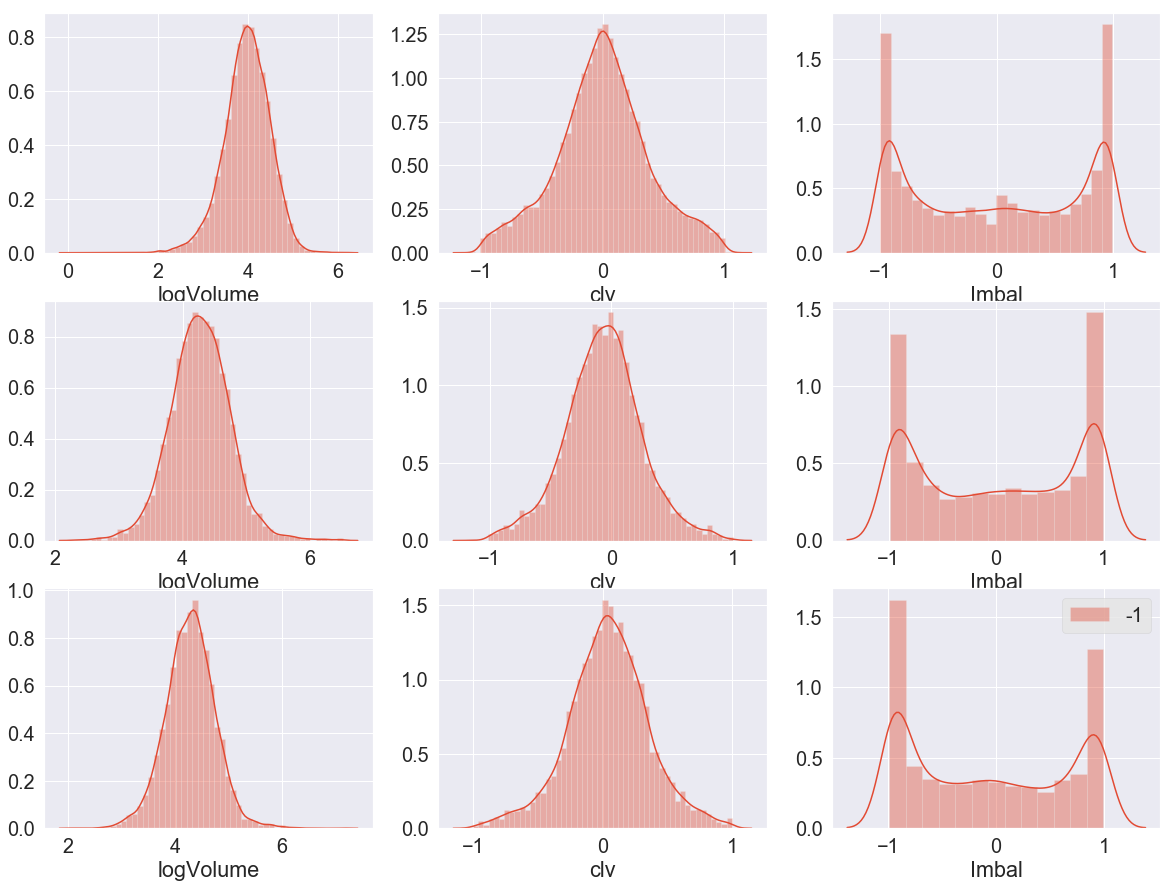

In [11]:
fig,ax = plt.subplots(ncols=3,nrows=3,figsize=(20,15))
plt.style.use('ggplot')
sns.distplot(a=df_10s[df_10s['pxDir1']==0]['logVolume'],ax=ax[0][0],label='0')

sns.distplot(a=df_10s[df_10s['pxDir1']==1]['logVolume'],ax=ax[1][0],label='1')
sns.distplot(a=df_10s[df_10s['pxDir1']==-1]['logVolume'],ax=ax[2][0],label='-1')

sns.distplot(a=df_10s[df_10s['pxDir1']==0]['clv'],ax=ax[0][1],label='0')
sns.distplot(a=df_10s[df_10s['pxDir1']==1]['clv'],ax=ax[1][1],label='1')
sns.distplot(a=df_10s[df_10s['pxDir1']==-1]['clv'],ax=ax[2][1],label='-1')

sns.distplot(a=df_10s[df_10s['pxDir1']==0]['Imbal'],ax=ax[0][2],label='0')
sns.distplot(a=df_10s[df_10s['pxDir1']==1]['Imbal'],ax=ax[1][2],label='1')
sns.distplot(a=df_10s[df_10s['pxDir1']==-1]['Imbal'],ax=ax[2][2],label='-1')

plt.legend()

+ Based on the the univariate distribution plots of **logVolume**, **clv** and **Imbal** features for 3 price movement directions, it is hard to tell the difference for each movement directions. I would say only based on the univariate distribution plots, we can not judge whether **logVolume**, **clv** and **Imbal** are good features for predicting price movement directions.

#### Univariate distributions of targets: fwdRet1Bps, pxDir1

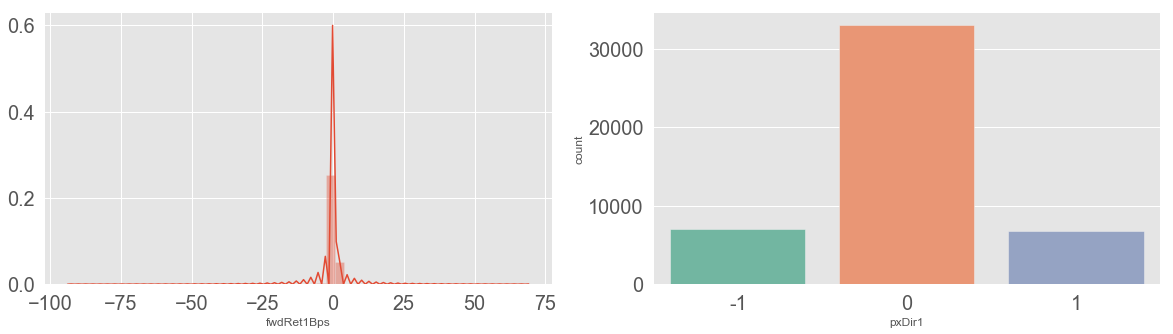

In [12]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(20,5))
plt.style.use('ggplot')
sns.distplot(a=df_10s['fwdRet1Bps'].dropna(),ax=ax[0])
sns.countplot(df_10s['pxDir1'],ax=ax[1],palette='Set2')

+ We can see that **fwdRet1Bps** are concentrated around 0, which causes **pxDir1** has dominated 0. 

In [ ]:
features = ['logVolume', 'clv', 'Imbal', 'fwdRet1Bps']
plt.rcParams
sns.heatmap(df_10s[features].corr(),cmap='Greens',annot=True)

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(15,5))

sns.distplot(a=df_10s['lastAskPx'],ax=ax[0][0])
sns.distplot(a=df_10s['lastAskSz'],ax=ax[0][1])
sns.distplot(a=df_10s['lastBidPx'],ax=ax[1][0])
sns.distplot(a=df_10s['lastBidSz'],ax=ax[1][1])
plt.tight_layout()

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler

# function to split train and test sets into X and y sets 
def data_preprocess(train_set, test_set, feature_start=11, feature_end=14):
    X_train = train_set.iloc[:, feature_start:feature_end].values # logVolume, clt, Imbal
    y_train = train_set.iloc[:, -1].values # pxDir1
    X_test = test_set.iloc[:, feature_start:feature_end].values  
    y_test = test_set.iloc[:, -1].values
    
    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    # Transform {-1, 0, 1}  into 3 categories 
    n_classes = 3
    y_train = np_utils.to_categorical(y_train,n_classes)
    y_test = np_utils.to_categorical(y_test,n_classes)
    return X_train, y_train, X_test, y_test

X_train10s, y_train10s, X_test10s, y_test10s = data_preprocess(train_set10s, test_set10s, 11, 14)


### Bulid Baseline Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def build_baseline_model(train_set, test_set):
    prior_pos = len(train_set[train_set['pxDir1']==1]) / len(train_set)
    prior_neg = len(train_set[train_set['pxDir1']==-1]) / len(train_set)
    prior_neu = len(train_set[train_set['pxDir1']==0]) / len(train_set)
    test_set['rand'] = np.random.uniform(0,1,len(test_set))
    y_pred = []
    for i in range(len(test_set)):
        if test_set['rand'].iloc[i] <= prior_neg:
            y_pred.append(-1)
        elif test_set['rand'].iloc[i] <= prior_neg+prior_neu:
            y_pred.append(0)
        else:
            y_pred.append(-1)
 
    return y_pred
            
def baseline_model_performance(train_set, test_set):
    y_pred = build_baseline_model(train_set, test_set)
    y_test = test_set['pxDir1'].values.tolist()
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1_wght = f1_score(y_test, y_pred, average='weighted')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    df_performance = pd.DataFrame({'Model': 'Baseline', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1wght':  f1_wght, 'F1micro': f1_micro}, index=[0])
    return df_performance 
    

baseline_model_performance(train_set10s, test_set10s)

### Bulid NN Model

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense 


def build_NN_model(X_train, y_train, n_features=3):
    model = Sequential()
    model.add(Dense(30, input_dim = n_features, activation = 'relu'))
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(3, activation = 'softmax'))
#     model.summary()
    model.compile(loss = 'categorical_crossentropy' , optimizer='adam', metrics = ['accuracy'] )
    model.fit(X_train, y_train, epochs = 40, batch_size = 100, verbose=0)
    return model

def NN_performance(X_test, test_set, model):    
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    for i in range(len(y_pred)):
        if y_pred[i] == 2:
            y_pred[i] = -1

    y_test = test_set['pxDir1']
    precision = precision_score(y_test, y_pred, average='weighted',labels=np.unique(y_pred))
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1_wght = f1_score(y_test, y_pred, average='weighted',labels=np.unique(y_pred))
    f1_micro = f1_score(y_test, y_pred, average='micro',labels=np.unique(y_pred))

    df_performance = pd.DataFrame({'Model': 'NN', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1wght':  f1_wght, 'F1micro': f1_micro}, index=[0])
    return df_performance 

model = build_NN_model(X_train10s, y_train10s)
NN_performance(X_test10s, test_set10s, model)

### Logistical Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def bulid_LR_model(X_train, y_train):
    model = LogisticRegression(C=1e-3, multi_class='multinomial', solver='lbfgs', max_iter=100)
    model.fit(X_train, y_train)
    return model

def model_performance(X_test, y_test, model):
    model_name = str(type(model).__name__)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, average='weighted',labels=np.unique(y_pred))
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1_wght = f1_score(y_test, y_pred, average='weighted',labels=np.unique(y_pred))
    f1_micro = f1_score(y_test, y_pred, average='micro',labels=np.unique(y_pred))
    df_performance = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1wght':  f1_wght, 'F1micro': f1_micro}, index=[0])
    return df_performance 
    

y_train10s = train_set10s['pxDir1'].values.tolist()
model = bulid_LR_model(X_train10s, y_train10s)
y_test10s = test_set10s['pxDir1']
model_performance(X_test10s, y_test10s, model)


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def bulid_RF_model(X_train, y_train):
    model = RandomForestClassifier(criterion = 'entropy',  n_estimators=20, max_depth=6, random_state = 0)
    model.fit(X_train, y_train)
    return model 

model = bulid_RF_model(X_train10s, y_train10s)
model_performance(X_test10s, y_test10s, model)

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def bulid_AdaBoost_model(X_train, y_train):
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                               n_estimators=200,algorithm="SAMME.R", learning_rate=0.1, random_state=0)
    model.fit(X_train, y_train)
    return model 

model = bulid_AdaBoost_model(X_train10s, y_train10s)
model_performance(X_test10s, y_test10s, model)                                

### 1-min Dataset Testing

In [ ]:
df_1min = dataset.copy()
df_1min['dateTime'] =  pd.to_datetime(df_1min['date' ] + ' ' + df_1min['time'])
df_1min.set_index('dateTime', inplace=True)

volume = df_1min['volume'].resample('1T').sum()
df_1min['vol*vwap'] = df_1min['volume'] * df_1min['vwap']
vol_times_vwap_1min = df_1min['vol*vwap'].resample('1T').sum()
vwap = vol_times_vwap_1min/volume
df_1min.drop('vol*vwap', axis=1, inplace=True)

lowPx = df_1min['lowPx'].resample('1T').min()
highPx = df_1min['highPx'].resample('1T').max()
lastBidPx = df_1min['lastBidPx'].resample('1T').last()
lastAskPx = df_1min['lastAskPx'].resample('1T').last()
lastBidSz = df_1min['lastBidSz'].resample('1T').last()
lastAskSz = df_1min['lastAskSz'].resample('1T').last()
sym = df_1min['sym'].resample('1T').last()

df_1min = pd.DataFrame({'sym': sym, 'volume': volume, 'vwap': vwap, 'lowPx': lowPx, 'highPx': highPx, 'lastBidPx': lastBidPx, 'lastAskPx': lastAskPx, 'lastBidSz': lastBidSz, 'lastAskSz': lastAskSz})
df_1min.head(10000)

# df_1min = df_1min.resample('1T').sum() # re-aggregate 10-sec data into 1-min data 
df_1min = df_1min[df_1min.index.weekday<5] # filter the weekend 
df_1min = df_1min.reset_index()
df_1min['date'] = df_1min['dateTime'].dt.strftime('%d/%m/%Y')
df_1min['time'] = df_1min['dateTime'].dt.strftime('%H:%M:%S')
time_mask = (df_1min['time']>='09:30:00') & (df_1min['time']<='16:00:00') # filter not the daily trading time 
df_1min = df_1min.loc[time_mask].drop(['dateTime'], axis=1)
df_1min = df_1min.reset_index(drop=True)
df_1min['sym'] = 'SPY' # add back sym 
df_1min.head(10)

In [ ]:
df_1min = update_features(df_1min)   
df_1min, train_set_1min, test_set_1min = train_test_split(df_1min)
cols = df_10sec.columns.tolist()
df_1min = df_1min[cols]
df_1min.head(10)

### Baseline - 1min

In [ ]:
df_1min, train_set1min, test_set1min = train_test_split(df_1min)
baseline_model_performance(train_set1min, test_set1min)

### NN - 1min

In [ ]:
X_train1min, y_train1min, X_test1min, y_test1min = data_preprocess(train_set1min, test_set1min)
model = build_NN_model(X_train1min, y_train1min)
NN_performance(X_test1min, test_set1min, model)

### Logistical Regression - 1min

In [ ]:
y_train1min = train_set1min['pxDir1'].values.tolist()
model = bulid_LR_model(X_train1min, y_train1min)
y_test1min = test_set1min['pxDir1']
model_performance(X_test1min, y_test1min, model)

### Random Forest - 1min

In [ ]:
model = bulid_RF_model(X_train1min, y_train1min)
model_performance(X_test1min, y_test1min, model)

### AdaBoost

In [ ]:
model = bulid_AdaBoost_model(X_train1min, y_train1min)
model_performance(X_test1min, y_test1min, model) 

### Extra Improvement 
#### adding Rolling mean of vwap

In [ ]:
df_10s = dataset.copy()
df_10s = update_features(df_10s) 
df_10s['rolling_vwap'] = df_10s.vwap.rolling(window=10, center=False).mean()
df_10s = df_10s.dropna()
df_10s.head(10)

In [ ]:
cols = ['date', 'time', 'sym', 'volume', 'vwap', 'lowPx', 'highPx', 'lastBidPx', 'lastAskPx', 'lastBidSz', 'lastAskSz', 'logVolume','clv', 'Imbal', 'rolling_vwap', 'fwdRet1Bps']  
df_10s = df_10s[cols]
df_10s.head(10)

In [ ]:
df_10s, train_set10s, test_set10s = train_test_split(df_10s)
X_train10s, y_train10s, X_test10s, y_test10s = data_preprocess(train_set10s, test_set10s, 11, 15)

In [ ]:
baseline_model_performance(train_set10s, test_set10s)

In [ ]:
model = build_NN_model(X_train10s, y_train10s, 4)
NN_performance(X_test10s, test_set10s, model)

In [ ]:
y_train10s = train_set10s['pxDir1'].values.tolist()
model = bulid_LR_model(X_train10s, y_train10s)
y_test10s = test_set10s['pxDir1']
model_performance(X_test10s, y_test10s, model)

In [ ]:
df_10s = dataset.copy()
df_10s = update_features(df_10s) 
df_10s['volumn_diff'] = df_10s.volume.diff()
df_10s = df_10s.dropna()
df_10s.head(10)

In [ ]:
cols = ['date', 'time', 'sym', 'volume', 'vwap', 'lowPx', 'highPx', 'lastBidPx', 'lastAskPx', 'lastBidSz', 'lastAskSz', 'logVolume','clv', 'Imbal', 'volumn_diff', 'fwdRet1Bps']  
df_10s = df_10s[cols]
df_10s.head(10)

In [ ]:
df_10s, train_set10s, test_set10s = train_test_split(df_10s)
X_train10s, y_train10s, X_test10s, y_test10s = data_preprocess(train_set10s, test_set10s, 11, 15)

In [ ]:
y_train10s = train_set10s['pxDir1'].values.tolist()
model = bulid_LR_model(X_train10s, y_train10s)
y_test10s = test_set10s['pxDir1']
model_performance(X_test10s, y_test10s, model)